In [2]:
import numpy
import torch
import matplotlib.pyplot as plt
import cv2
import supervision as sv
# import torchvision.transforms.functional as F
import numpy as np

from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

device = torch.device('cpu')

In [3]:
class SegmentAnything:
    def __init__(self, device, model_type, sam_checkpoint):
        print("init Segment Anything")
        self.device = device
        self.sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        self.sam.to(self.device)

    def generat_masks(self, image):
        print("generate masks by Segment Anything")
        # 検出するマスクの品質　（default: 0.88)
        # pred_iou_thresh = 0.96 640*480の時ちょうどよかった
        pred_iou_thresh = 0.98  #  960×720の時はこれぐらい
        mask_generator_2 = SamAutomaticMaskGenerator(
            model=self.sam, pred_iou_thresh=pred_iou_thresh
        )
        masks = mask_generator_2.generate(image)
        self.sorted_anns = sorted(masks, key=(lambda x: x["area"]), reverse=True)
        self._length = len(masks)
        print("{} masks generated.".format(self._length))

    def generat_masks_all(self, image):
        print("generate masks by Segment Anything")
        # 検出するマスクの品質　（default: 0.88)
        # pred_iou_thresh = 0.96 640*480の時ちょうどよかった
        pred_iou_thresh = 0.98  #  960×720の時はこれぐらい
        mask_generator_2 = SamAutomaticMaskGenerator(
            model=self.sam, pred_iou_thresh=pred_iou_thresh
        )
        masks = mask_generator_2.generate(image)
        self.sorted_anns = sorted(masks, key=(lambda x: x["area"]), reverse=True)
        self._length = len(masks)
        print("{} masks generated.".format(self._length))
        return masks

    @property
    def length(self):
        return self._length

    def get(self, index):
        pixels = self.sorted_anns[index]["area"]
        mask = np.expand_dims(self.sorted_anns[index]["segmentation"], axis=-1)
        return mask, pixels

In [4]:
def read_image(file_name):
    image = cv2.imread(file_name)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    return image, height, width


In [5]:
image, height, width = read_image('image/fd400708.jpg')
image = cv2.resize(image,(160,120))


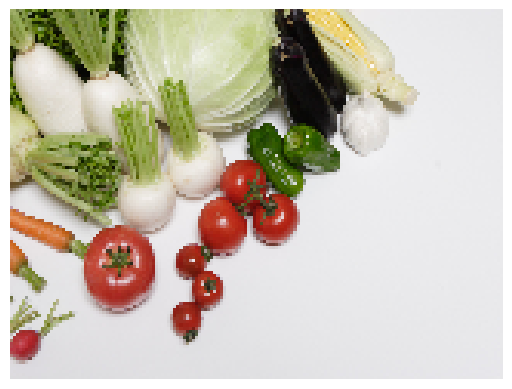

In [6]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [75]:
#segment anything クラスを生成
sam = SegmentAnything(device, "vit_b", "../models/sam_vit_b_01ec64.pth")

init Segment Anything


In [84]:
# マスク生成
sam.generat_masks_all(image)

AttributeError: 'SegmentAnything' object has no attribute 'generat_masks_all'

In [ ]:
print()

In [65]:
# エリアを検出するクラス
class Area:
    def __init__(self, width, height):
        self.x1 = width
        self.x2 = 0
        self.y1 = height
        self.y2 = 0

    def set(self, x, y):
        if x < self.x1:
            self.x1 = x
        if self.x2 < x:
            self.x2 = x
        if y < self.y1:
            self.y1 = y
        if self.y2 < y:
            self.y2 = y

    def get(self):
        return self.x1, self.y1, self.x2, self.y2

In [72]:
data_list = []
    # 一定のサイズのものだけを抽出する
max_pixels = 300
min_pixels = 100

for index in range(sam.length):
    mask, pixels = sam.get(index)

    # 一定範囲のサイズのみ対象にする
    if pixels < min_pixels or max_pixels < pixels:
        continue

    # 輪郭検出用の2値のテンポラリ画像
    mono_image = np.full(np.array([height, width, 1]), 255, dtype=np.uint8)
    # 個々の食品を切取るためのテンポラリ画像
    food_image = image.copy()

    area = Area(width, height)
    for y in range(height):
        for x in range(width):
            if mask[y][x]:
                mono_image[y][x] = 0  # ２値画像は、マスク部分を黒にする
                area.set(x, y)
            else:
                food_image[y][x] = [255, 255, 255]  # 食品切取り画像は、マスク部分以外を白にする

    # 検出範囲
    x1, y1, x2, y2 = area.get()
    # 食品の輪郭を取得する
    contours, _ = cv2.findContours(
        mono_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    # 食品画像を切取る
    food_image = food_image[y1:y2, x1:x2]

IndexError: index 160 is out of bounds for axis 0 with size 160

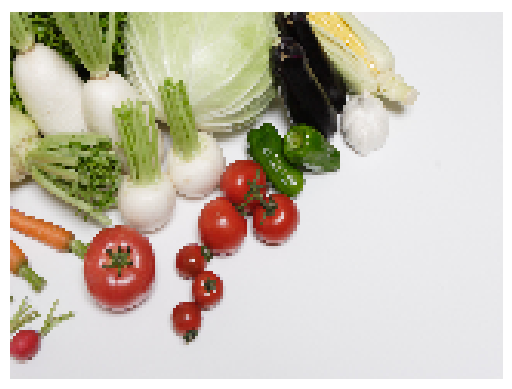

In [71]:
plt.imshow(food_image)
plt.axis("off")
plt.show()